In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy

import jax
import jax.numpy as jnp

In [2]:
x = jnp.array([1,2,3,4])
x[1]

2022-02-28 19:40:59.532612: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-28 19:40:59.534386: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-02-28 19:40:59.534412: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-02-28 19:40:59.535323: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:632] failed to get PTX kernel "compare_3" from module: CUDA_ERROR_NOT_FOUND: named symbol not found
2022-02-28 19:40:59.535346: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_

RuntimeError: INTERNAL: Could not find the corresponding function

In [2]:
def mean_control_effort_coefficients(x0, dx0, xf, dxf):
    """Returns `(c4, c3, c2)` corresponding to `c4 * tf**-4 + c3 * tf**-3 + c2 * tf**-2`."""
    return (12 * (x0 - xf)**2, 12 * (dx0 + dxf) * (x0 - xf), 4 * dx0**2 + 4 * dx0 * dxf + 4 * dxf**2)


def cubic_spline_coefficients(x0, dx0, xf, dxf, tf):
    return (x0, dx0, -2 * dx0 / tf - dxf / tf - 3 * x0 / tf**2 + 3 * xf / tf**2,
            dx0 / tf**2 + dxf / tf**2 + 2 * x0 / tf**3 - 2 * xf / tf**3)


def compute_interpolating_spline(state_0, state_f, tf=None):
    x0, y0, q0, v0 = state_0
    xf, yf, qf, vf = state_f
    dx0, dy0 = v0 * jnp.cos(q0), v0 * jnp.sin(q0)
    dxf, dyf = vf * jnp.cos(qf), vf * jnp.sin(qf)
    if tf is None:
        c4, c3, c2 = [
            a + b for a, b in zip(mean_control_effort_coefficients(x0, dx0, xf, dxf),
                                  mean_control_effort_coefficients(y0, dy0, yf, dyf))
        ]
        c, b, a = -4 * c4, -3 * c3, -2 * c2
        d = b**2 - 4 * a * c
        tf = (-b + jnp.sqrt(d)) / (2 * a)
        tf = jnp.where((d < 0) | (tf < 0), jnp.maximum(jnp.hypot(x0 - xf, y0 - yf), 1), tf)
    return (
        jnp.array(cubic_spline_coefficients(x0, dx0, xf, dxf, tf)),
        jnp.array(cubic_spline_coefficients(y0, dy0, yf, dyf, tf)),
        tf,
    )

## Free Final Time
Minimizing mean control effort happens to have a closed-form solution for the local optimum (if it exists); the global optimum is of course at `tf → ∞`. Alternatively we could consider a mixed time/control effort penalty and optimize numerically.

In [3]:
state_0 = np.array([0, 0, 0, 10.])
state_f = np.array([
    np.array([x, y, q, v]) for x in [24, 30, 36] for y in [-4, 0, 4] for q in [-np.pi / 12, 0, np.pi / 12]
    for v in [8, 10, 12]
])

In [4]:
def compute_spline_xyvat(x_coefficients, y_coefficients, tf, N=30):
    t = jnp.linspace(0, tf, N)
    tp = t[:, None]**np.arange(4)
    dtp = t[:, None]**np.array([0, 0, 1, 2]) * np.arange(4)
    ddtp = t[:, None]**np.array([0, 0, 0, 1]) * np.array([0, 0, 2, 6])
    return (
        tp @ x_coefficients,
        tp @ y_coefficients,
        jnp.hypot(dtp @ x_coefficients, dtp @ y_coefficients),
        jnp.hypot(ddtp @ x_coefficients, ddtp @ y_coefficients),
        t,
    )

In [5]:
xc, yc, tf = jax.vmap(compute_interpolating_spline, in_axes=(None, 0))(state_0, state_f)
x, y, v, a, t = jax.vmap(compute_spline_xyvat)(xc, yc, tf)
plt.figure(figsize=(20, 10))
plt.plot(x.T, y.T);

2022-02-28 17:52:13.277281: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-28 17:52:13.279267: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-02-28 17:52:13.279296: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-02-28 17:52:13.337112: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:632] failed to get PTX kernel "slice_2" from module: CUDA_ERROR_NOT_FOUND: named symbol not found
2022-02-28 17:52:13.337158: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_cl

RuntimeError: INTERNAL: Could not find the corresponding function

## Fixed Final Time

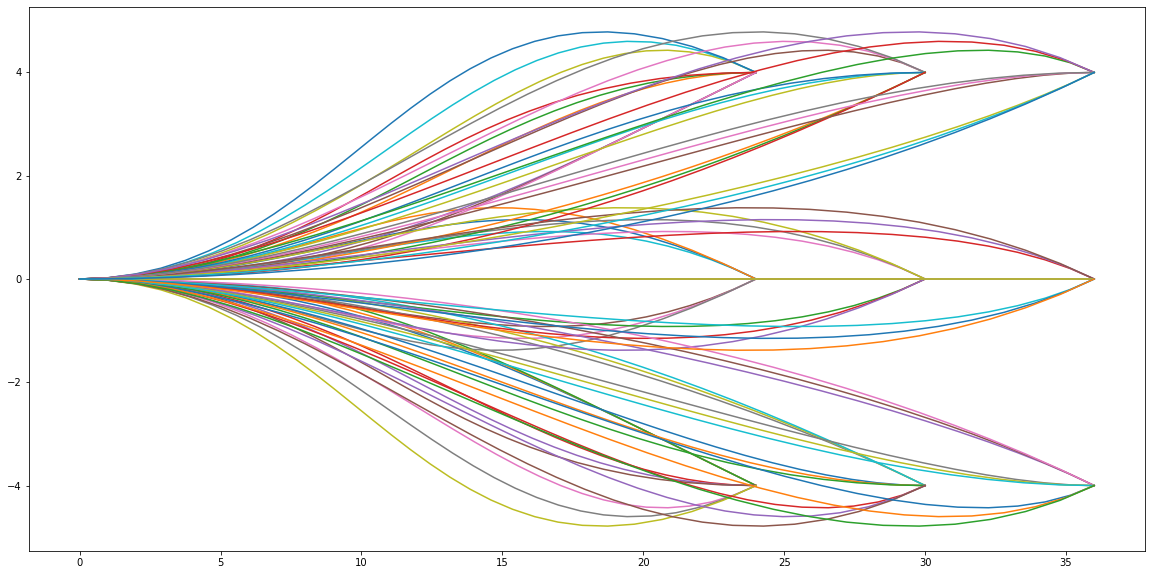

In [6]:
xc, yc, tf = jax.vmap(lambda s0, s1: compute_interpolating_spline(s0, s1, 3), in_axes=(None, 0))(state_0, state_f)
x, y, v, a, t = jax.vmap(compute_spline_xyvat)(xc, yc, tf)
plt.figure(figsize=(20, 10))
plt.plot(x.T, y.T);

## Derivations
Precomputing these expressions saves a bit of computation over doing linear system solves online.

In [3]:
t, tf = sympy.symbols("t, t_f")
x0, dx0, xf, dxf = sympy.symbols("x_0, \dot{x}_0, x_f, \dot{x}_f")
symbols_to_variables = [(tf, "tf"), (x0, "x0"), (dx0, "dx0"), (xf, "xf"), (dxf, "dxf")]

In [4]:
monomials = sympy.Array(t**np.arange(4))
coefficients = sympy.Matrix([
    monomials.subs(t, 0),
    sympy.diff(monomials, t).subs(t, 0),
    monomials.subs(t, tf),
    sympy.diff(monomials, t).subs(t, tf)
]).LUsolve(sympy.Matrix([x0, dx0, xf, dxf])).expand()
coefficients

Matrix([
[                                                              x_0],
[                                                        \dot{x}_0],
[   -2*\dot{x}_0/t_f - \dot{x}_f/t_f - 3*x_0/t_f**2 + 3*x_f/t_f**2],
[\dot{x}_0/t_f**2 + \dot{x}_f/t_f**2 + 2*x_0/t_f**3 - 2*x_f/t_f**3]])

In [6]:
monomials

[1, t, t**2, t**3]

In [9]:
mean_control_effort = sympy.integrate(sympy.diff(coefficients.dot(monomials), t, 2)**2 / tf, (t, 0, tf)).expand()
mean_control_effort

4*\dot{x}_0**2/t_f**2 + 4*\dot{x}_0*\dot{x}_f/t_f**2 + 12*\dot{x}_0*x_0/t_f**3 - 12*\dot{x}_0*x_f/t_f**3 + 4*\dot{x}_f**2/t_f**2 + 12*\dot{x}_f*x_0/t_f**3 - 12*\dot{x}_f*x_f/t_f**3 + 12*x_0**2/t_f**4 - 24*x_0*x_f/t_f**4 + 12*x_f**2/t_f**4

In [10]:
sympy.pycode(np.array(coefficients.subs(symbols_to_variables)).ravel()), sympy.pycode([
    c.subs(symbols_to_variables)
    for c in reversed(sympy.factor(sympy.Poly((tf**4 * mean_control_effort), tf).all_coeffs()))
])

('  # Not supported in Python:\n  # ImmutableDenseNDimArray\n[x0, dx0, -2*dx0/tf - dxf/tf - 3*x0/tf**2 + 3*xf/tf**2, dx0/tf**2 + dxf/tf**2 + 2*x0/tf**3 - 2*xf/tf**3]',
 '[12*(x0 - xf)**2, 12*(dx0 + dxf)*(x0 - xf), 4*dx0**2 + 4*dx0*dxf + 4*dxf**2]')